<img src = "banner.jpeg" />

## AI FASHION DISCRIMINATOR

    AI Fashion Discriminator is a tool based on Convolutional Neural Networks that analyzes your ouftit be it as a picture you feed it manually or as a picture taken directly from your webcam.
    
    It helps you make better fashion decisions before going outside!

## **IMPORTS**

In [1]:

#!pip install imageio
#!pip install opencv-python
#!pip install matplotlib
#!pip install seaborn
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
import seaborn as sns
import time
import scipy as sp

sns.set_theme()

## Setting up path and labels 

In [ ]:
path="/home/ch0ry/Documents/AI-Fashion-Discriminator/Dataset/"

categories = ["Formal", "Preppy", "Sportswear", "Techwear"]

## **Manipulating images**

In [17]:

def clean_background(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

    hh, ww = thresh1.shape

    # make bottom 2 rows black where they are white the full width of the image
    thresh1[hh-3:hh, 0:ww] = 0

    # get bounds of white pixels
    white = np.where(thresh1==255)
    xmin, ymin, xmax, ymax = np.min(white[1]), np.min(white[0]), np.max(white[1]), np.max(white[0])
    #print(xmin,xmax,ymin,ymax)

    # crop the image at the bounds adding back the two blackened rows at the bottom
    crop = img[ymin:ymax+3, xmin:xmax]

    crop = cv2.resize(crop, (175, 350))

    return crop

import glob

#Path for Windows usage
#path = "C:/Users/juanp/Documents/AI Fashion Discriminator/Dataset"




#good_img = [clean_background(cv2.resize(cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB), (350, 700))) for file in glob.glob(path + '/Good/NoBg/*.png')]

#bad_img = [clean_background(cv2.resize(cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB), (350, 700))) for file in glob.glob(path + '/Bad/NoBg/*.png')]


## GET RAW IMAGES

In [52]:

data = []

row = []

for cat in categories:
    
    row = [cv2.imread(file) for file in glob.glob(path + cat +'/*.jpg')]
    
    data.append(row)

## GET CLEANED IMAGES

In [54]:
data = []

row = []

for cat in categories:
    
    row = [clean_background(cv2.cvtColor(cv2.imread(file), cv2.COLOR_RGB2BGR)) for file in glob.glob(path + cat +'/NoBg/*.png')]
    
    data.append(row)

## **THIS BLOCK IS USED TO REMOVE BACKGROUND FROM IMAGES, ONLY USE WHEN NEW IMAGES ARE ADDED**

In [53]:

#!pip install --ignore-installed --pre onnxruntime-gpu --user
#!pip install rembg[gpu] --user
from rembg import remove


idx = 0
for cat in data:
    label = categories[idx]
    idx +=1
    seq = 0
    for input in cat:
        output_path = path+"/" + label + "/NoBg/"+label+"Clean{}.png".format(seq)
        output = remove(input)
        cv2.imwrite(output_path, output)
        seq += 1


## **Dataset showcase**

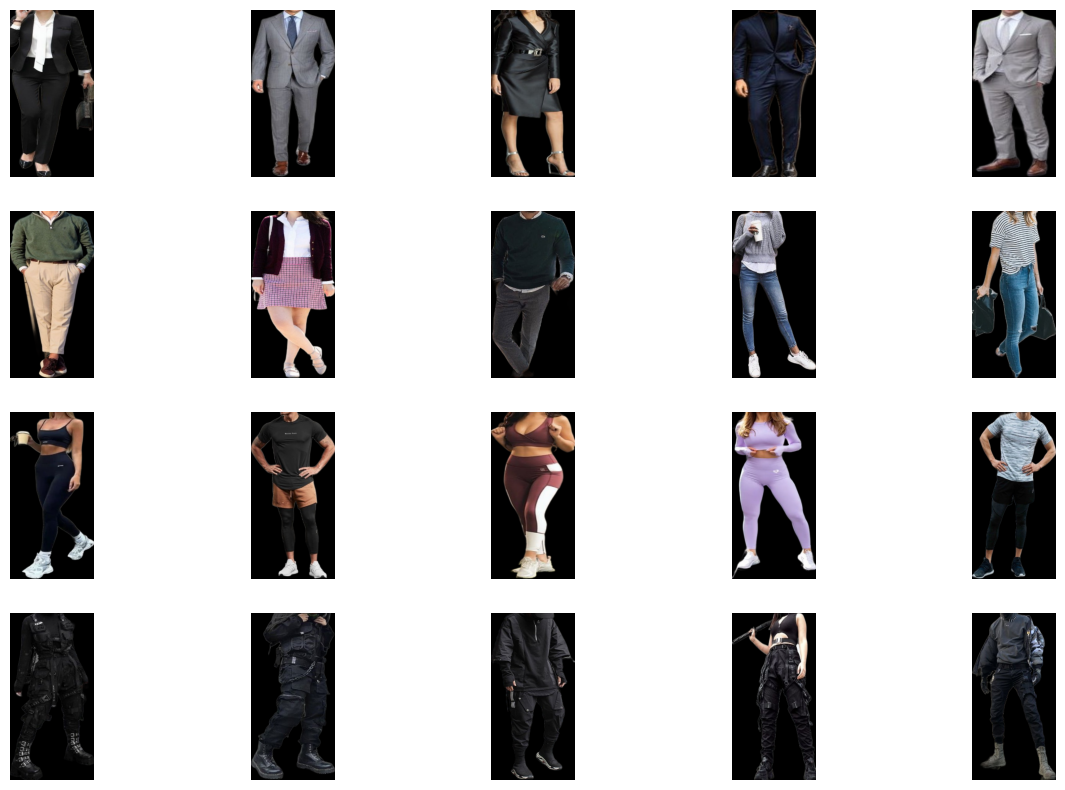

In [55]:
import math
fig = plt.figure(figsize = (15, 10))

rows = len(categories)
columns = 5

for i in range(rows*columns):
  
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(data[math.floor(i/columns)][i - math.floor(i/columns)*columns])
  plt.axis('off')
  #plt.title(i+1)


plt.show()

## **Model implementation**

## Preparing data, designing and training the CNN

In [181]:
#@title **Preparing data**
#!pip install scikit-learn
#!pip install tensorflow
#!pip install keras
#!pip install protobuf==3.19.4 --user

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import *




models = []
histories = []


#Se crean los arrays para ser usados en clasificacion


for i in range(len(categories)-1):

    X = list()
    y = list()
    
    base_model = tf.keras.models.Sequential()
    base_model.add(layers.Conv2D(32, (2, 2), activation='relu' ,input_shape=(350, 175, 3)))
    base_model.add(layers.MaxPooling2D((2, 2), padding='same'))
    base_model.add(layers.Conv2D(32, (2, 2), activation='relu'))
    base_model.add(layers.Dropout(0.2))
    base_model.add(layers.MaxPooling2D((2, 2), padding='same'))
    base_model.add(layers.Conv2D(16, (4, 4), activation='relu'))
    base_model.add(layers.Flatten())
    base_model.add(layers.Dense(128, activation='relu'))
    base_model.add(layers.Dense(1, activation='sigmoid'))
    
    
    
    
    for img in data[i]:
        X.append(np.asarray(img))
        y.append(1)
    
    for j in range(i+1, len(categories)):
        
        for img in data[j]:
            X.append(np.asarray(img))
            y.append(0) 
        
        

    #Se convierten las listas en arrays de NumPy, para reducirlos a arreglos bidimensionales que lee el estimador

    X = np.asarray(X)
    
    #X = np.reshape(X,(X.shape[0], (X.shape[1]*X.shape[2])))  40
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    
    base_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

    y_test = np.asarray(y_test)

    y_train = np.asarray(y_train)
    
    history = base_model.fit(X_train, y_train, epochs=5,
                        validation_data=(X_test, y_test), verbose=True)
    
    histories.append(history)
    models.append(base_model)
    
    


Epoch 1/5
8/8 [==============================] - 9s 917ms/step - loss: 136.2210 - accuracy: 0.5519 - val_loss: 1.2112 - val_accuracy: 0.7037
Epoch 2/5
8/8 [==============================] - 6s 780ms/step - loss: 1.6061 - accuracy: 0.7469 - val_loss: 0.9192 - val_accuracy: 0.7346
Epoch 3/5
8/8 [==============================] - 6s 797ms/step - loss: 0.4920 - accuracy: 0.8091 - val_loss: 0.5762 - val_accuracy: 0.7407
Epoch 4/5
8/8 [==============================] - 6s 770ms/step - loss: 0.2424 - accuracy: 0.9585 - val_loss: 0.5488 - val_accuracy: 0.7407
Epoch 5/5
8/8 [==============================] - 6s 798ms/step - loss: 0.1328 - accuracy: 0.9461 - val_loss: 0.6146 - val_accuracy: 0.7654
Epoch 1/5
6/6 [==============================] - 5s 797ms/step - loss: 147.9404 - accuracy: 0.5444 - val_loss: 1.6299 - val_accuracy: 0.5041
Epoch 2/5
6/6 [==============================] - 5s 788ms/step - loss: 0.9939 - accuracy: 0.7389 - val_loss: 1.0052 - val_accuracy: 0.6860
Epoch 3/5
6/6 [========

In [170]:
def feedForward(img):
    #print(img.shape)
    for i in range(len(models)):
        pred = models[i].predict(img)[0][0]
        print(pred)
        if pred >= 0.5:
            return i
    return len(models)

        

In [185]:
#np.asarray(data[0][0]).shape
feedForward(np.expand_dims(data[1][10], axis=0))
#print(models[2].predict(np.expand_dims(data[2][5], axis=0))[0][0])

(1, 350, 175, 3)
1/1 [==============================] - 0s 41ms/step
0.0010923129
1/1 [==============================] - 0s 41ms/step
0.86574715


1

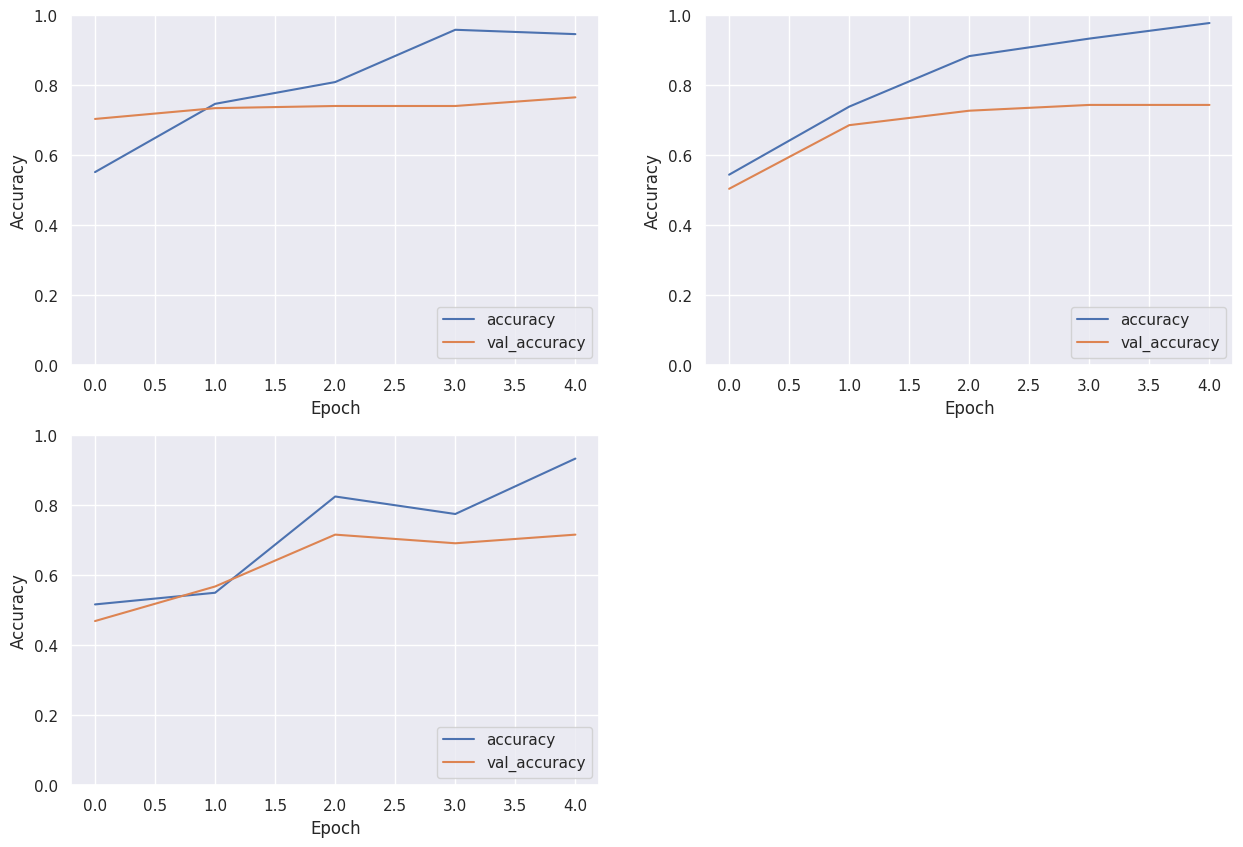

In [186]:
fig = plt.figure(figsize = (15, 10))

for history in histories:
    fig.add_subplot(2,2, histories.index(history)+1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.0, 1])
    plt.legend(loc='lower right')

<img src = "accuracy_graph.png" />

1/1 [==============================] - 0s 112ms/step
4


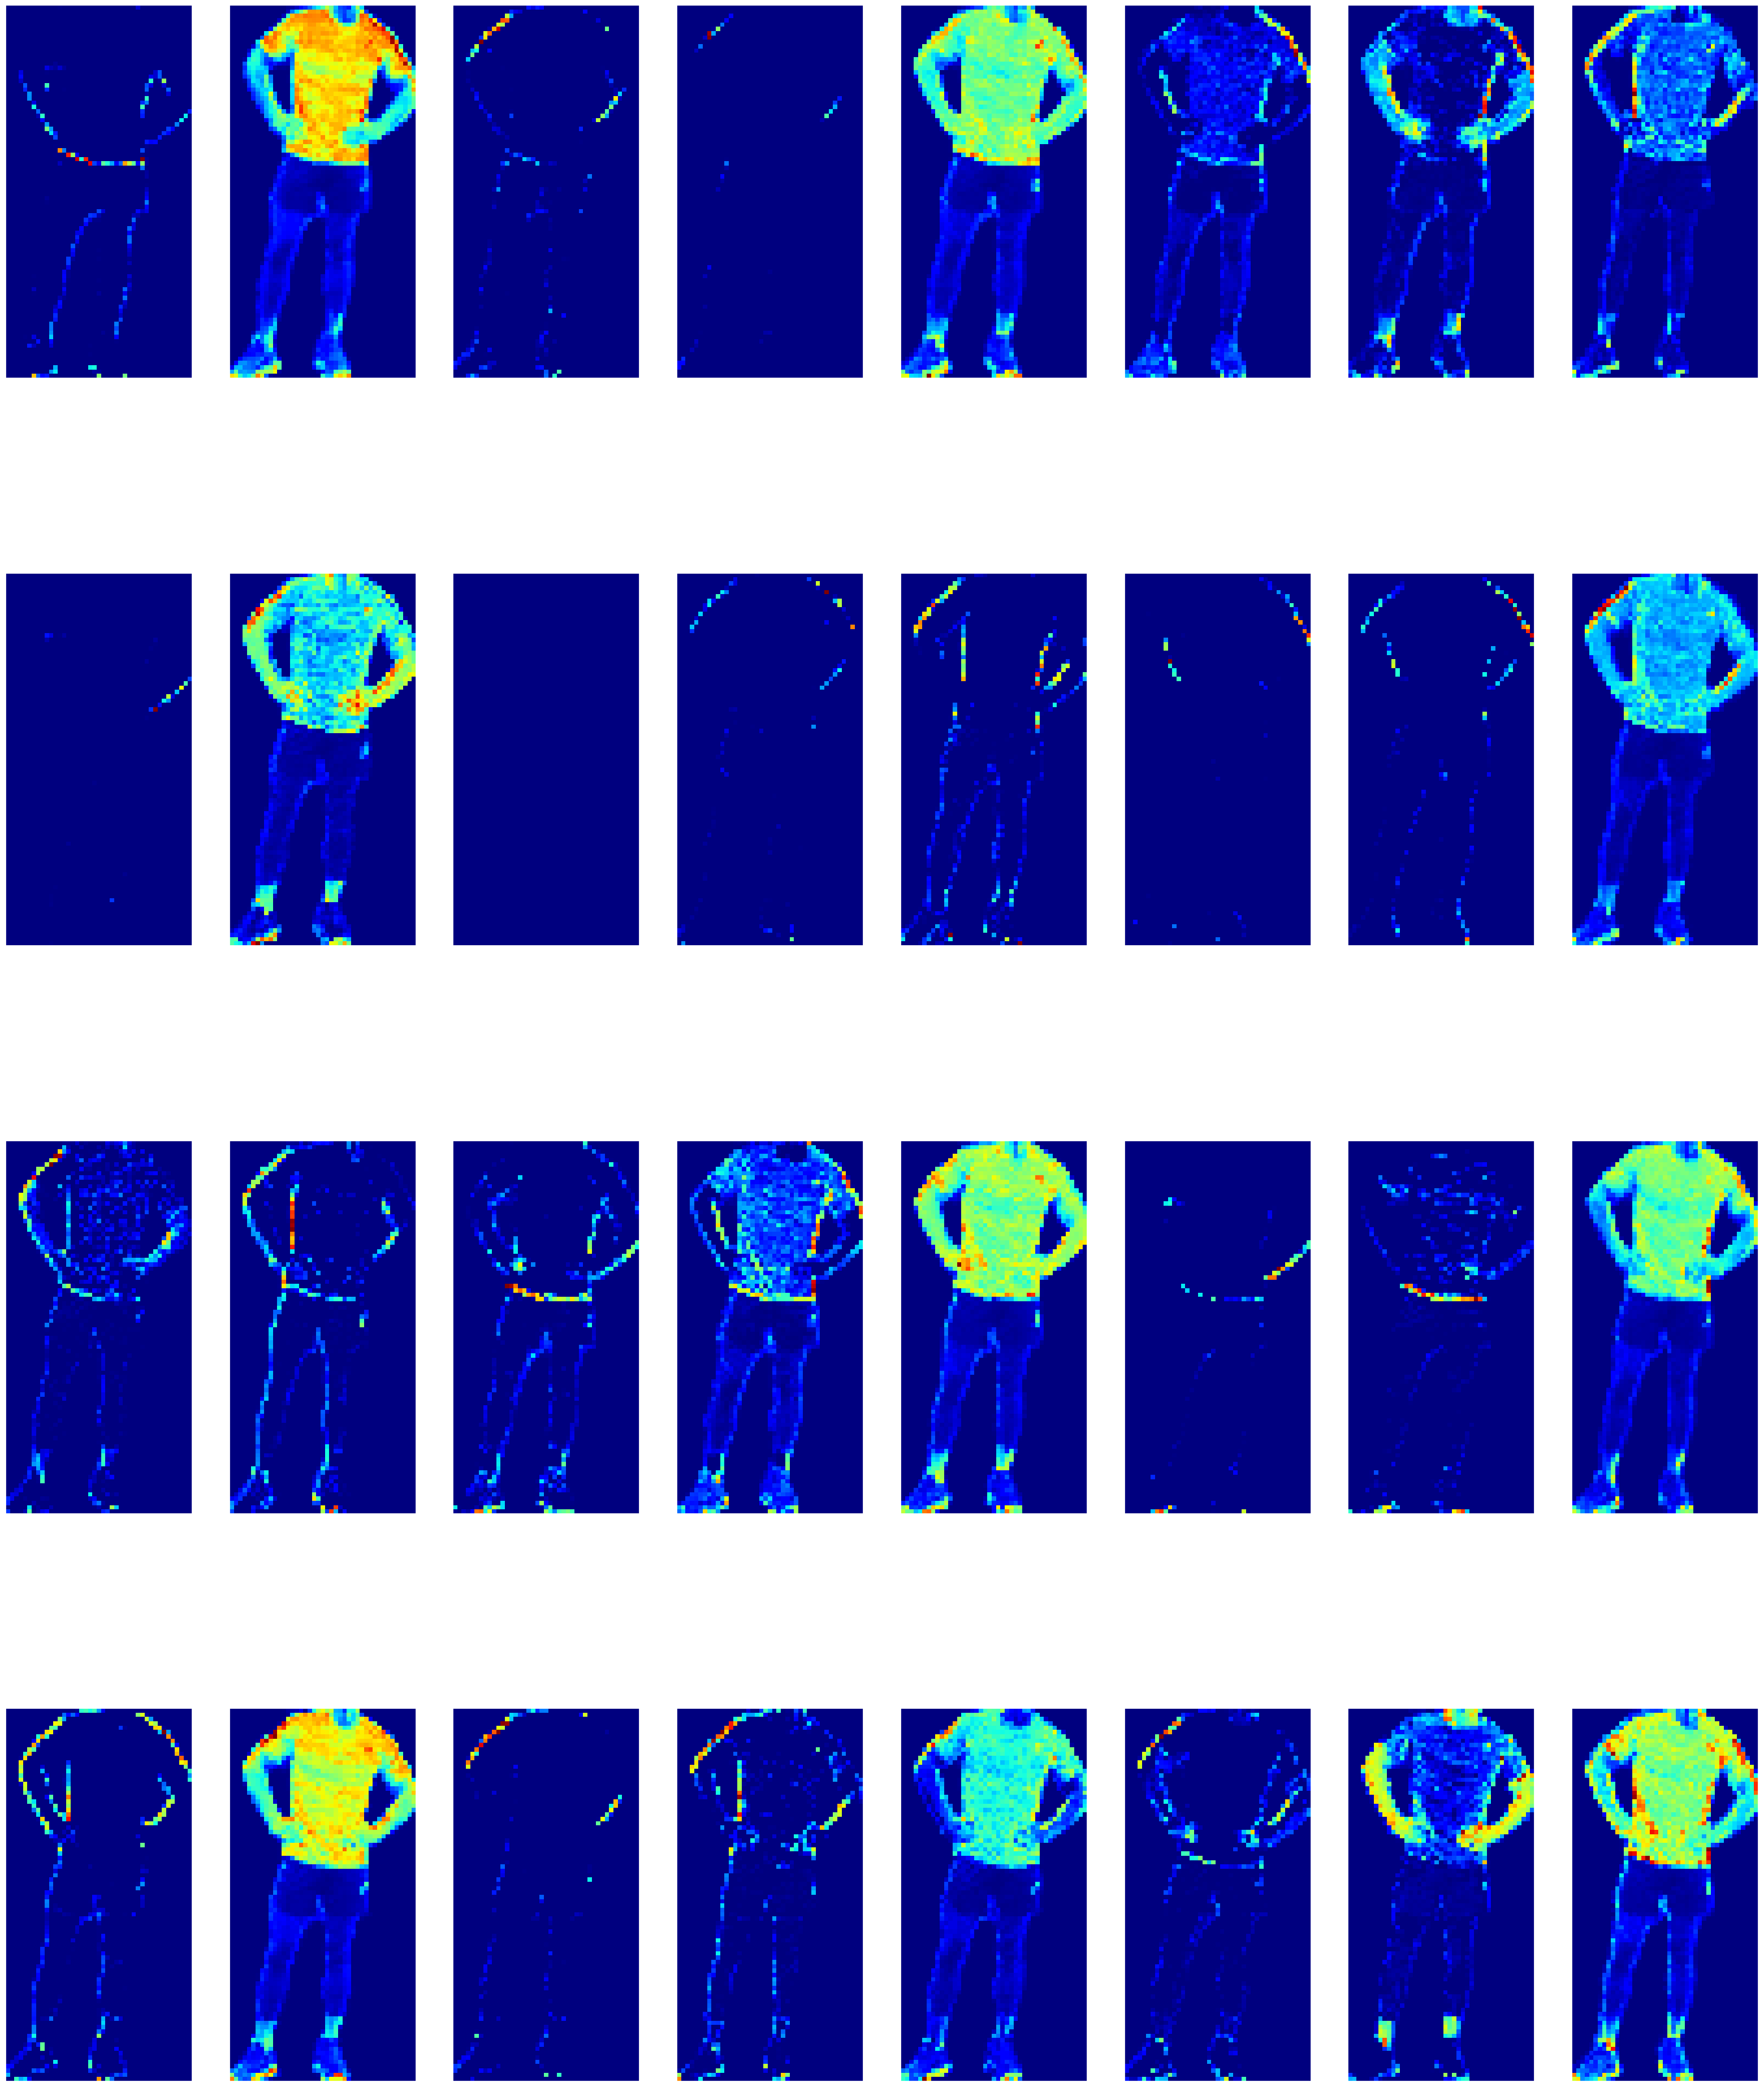

In [178]:
showActivations(4, models[0])

In [176]:



def showActivations(layerId, mod):
    
    layer_outputs = [layer.output for layer in mod.layers ]
    activation_model = tf.keras.models.Model(inputs=mod.input, outputs=layer_outputs)
    array = np.expand_dims(data[2][4], axis=0)
    activations = activation_model.predict(array)
    plt.figure(figsize=(40,50), dpi=100)
    
    layer = layer_outputs[layerId]
    
    activNum = layer.shape[3]
    
    base = 2
    
    if activNum > 20:
        print(math.ceil(activNum/10))
        
        base = math.ceil(activNum/10)

    for i in range(activNum):
        plt.subplot(base,math.ceil(activNum/base),i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(activations[layerId][0,:, :, i], cmap='jet')

## Loading the trained model for usage

In [10]:
import tensorflow as tf
import tensorflow.keras as keras
model = keras.models.load_model('model2.h5')

### Background removal, resizing and color correcting for prediction

In [29]:
from rembg import remove
def pred_img(img):
    img = clean_background(cv2.resize(cv2.cvtColor(remove(img), cv2.COLOR_BGR2RGB), (350, 700)))
    plt.imshow(img)
    plt.axis("off")

    answer = model.predict(np.asarray([img]))[0][0]
    print(answer)
    if answer >= 0.5:
      text = "Good"
    else:
      text = "Bad"

    return text

### Predicting images selected manually

1/1 [==============================] - 0s 26ms/step
4.7169234e-08


'Bad'

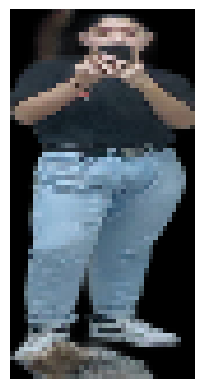

In [40]:
source = path+"/Test/T3.jpeg"

test = cv2.imread(source)
pred_img(test)

### Using webcam for taking pictures and predicting in real time

In [1]:
cap = cv2.VideoCapture(0)
cap.set(3,1920) # adjust width
cap.set(4,720) # adjust height
font = cv2.FONT_HERSHEY_SIMPLEX
img_counter = 0

wait = False
show = False

while True:
    success, img = cap.read()
    #cv2.rectangle(img, (300, 20), (1000, 700), (0, 255, 0), 5)
     # This will open an independent window
    cv2.imshow("Webcam", img)
    if show:
        cv2.putText(img, 
                text, 
                (400, 600), 
                font, 1, 
                (0, 255, 255), 
                2, 
                cv2.LINE_4)
        cv2.imshow("Webcam", img)
   
    k = cv2.waitKey(1)
    if k%256 == 32:
        t1 = time.time()
        wait = True
        show = False
        
    if  wait and time.time() - t1 > 2:
            img_name = "opencv_frame_{}.png".format(img_counter)
            cv2.imwrite(img_name, img)
            print("{} written!".format(img_name))
            img_counter += 1
            ss = cv2.imread(img_name)
            text = pred_img(ss)
            
            show = True
            wait = False
    if k%256 == 27: # quit when 'esc' is pressed
        cap.release()
        break
        
cv2.destroyAllWindows() 
cv2.waitKey(1)

NameError: name 'cv2' is not defined